## Adaptive optimizers

In this seminar you will implement a logistic regression and train it using stochastic gradient descent modiffications, numpy and your brain.

In [1]:
#load our dakka
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

## Two-dimensional classification

To make things more intuitive, let's solve a 2D classification problem with syntetic data.

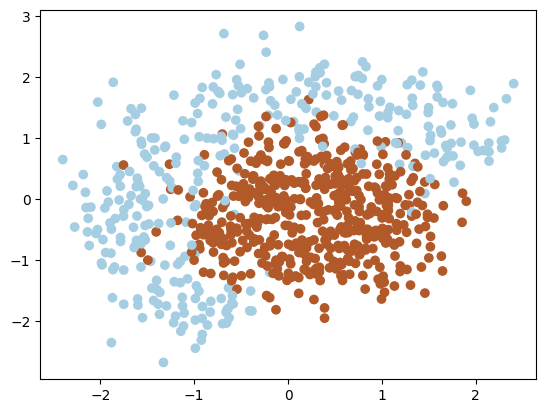

In [2]:
from sklearn import datasets, preprocessing

(X, y) = datasets.make_circles(n_samples=1024, shuffle=True, noise=0.2, factor=0.4)
ind = np.logical_or(y==1, X[:,1] > X[:,0] - 0.5)
X = X[ind,:]
m = np.array([[1, 1], [-2, 1]])
X = preprocessing.scale(X)
y = y[ind]


plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Paired)
plt.show()

In [3]:
print("X:\n{}\ny:\n{}".format(X[:3],y[:3]))

X:
[[ 0.13192158 -0.00999728]
 [-0.21777765  0.63268824]
 [-1.84231806 -0.32144948]]
y:
[1 1 0]


**Your task starts here**

Since the problem above isn't linearly separable, we add quadratic features to the classifier.

Implement this transformation in the __expand__ function __[1 point]__.

In [4]:
def expand(X):
    """
    Adds quadratic features.
    This function allows your linear model to make non-linear separation.

    For each sample (row in matrix), compute an expanded row:
    [feature0, feature1, feature0^2, feature1^2, feature0*feature1, 1]

    :param X: matrix of features, shape [n_samples,2]
    :returns: expanded features of shape [n_samples,6]
    """

    X_expanded = np.zeros((X.shape[0], 6))

    feature0 = X[:, 0]
    feature1 = X[:, 1]

    X_expanded[:, 0] = feature0
    X_expanded[:, 1] = feature1
    X_expanded[:, 2] = feature0 ** 2
    X_expanded[:, 3] = feature1 ** 2
    X_expanded[:, 4] = feature0 * feature1
    X_expanded[:, 5] = 1

    return X_expanded

In [5]:
#simple test on random numbers
#[all 8 random numbers are 100% random :P]
dummy_X = np.array([
        [0,0],
        [1,0],
        [2.61,-1.28],
        [-0.59,2.1]
    ])

# call your expand function
dummy_expanded = expand(dummy_X)

# what it should have returned:   x0       x1       x0^2     x1^2     x0*x1    1
dummy_expanded_ans = np.array([[ 0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  1.    ],
                               [ 1.    ,  0.    ,  1.    ,  0.    ,  0.    ,  1.    ],
                               [ 2.61  , -1.28  ,  6.8121,  1.6384, -3.3408,  1.    ],
                               [-0.59  ,  2.1   ,  0.3481,  4.41  , -1.239 ,  1.    ]])

# tests
assert isinstance(dummy_expanded,np.ndarray), "please make sure you return numpy array"
assert dummy_expanded.shape==dummy_expanded_ans.shape, "please make sure your shape is correct"
assert np.allclose(dummy_expanded,dummy_expanded_ans,1e-3), "Something's out of order with features"

print("Seems legit!")


Seems legit!


### Logistic regression (4 pts)
Now, let's write function that predicts class given X as in logistic regression.

The math should look like this:

$$ P(y| \vec x, \vec w) = \sigma(\vec x \cdot \vec w )$$

where x represents features, w are weights and $$\sigma(a) = {1 \over {1+e^{-a}}}$$

We shall omit $ \vec {arrows} $ in further formulae for simplicity.

In [6]:
def classify(X, w):
    """
    Given input features and weights
    return predicted probabilities of y==1 given x, P(y=1|x), see description above

    __don't forget to expand X inside classify and other functions__

    :param X: feature matrix X of shape [n_samples,2] (non-exanded)
    :param w: weight vector w of shape [6] for each of the expanded features
    :returns: an array of predicted probabilities in [0,1] interval.
    """
    # Expand the features first
    X_expanded = expand(X)

    # Compute the linear combination
    linear_output = np.dot(X_expanded, w)

    # Apply sigmoid function to get probabilities
    probabilities = 1 / (1 + np.exp(-linear_output))

    return probabilities

In [7]:
# sample usage / test just as the previous one
dummy_weights = np.linspace(-1,1,6)

dummy_probs = classify(dummy_X,dummy_weights)

dummy_answers = np.array([ 0.73105858,  0.450166  ,  0.02020883,  0.59844257])

assert isinstance(dummy_probs,np.ndarray), "please return np.array"
assert dummy_probs.shape == dummy_answers.shape, "please return an 1-d vector with answers for each object"
assert np.allclose(dummy_probs,dummy_answers,1e-3), "There's something non-canonic about how probabilties are computed"
print("Classification test passed!")


Classification test passed!


The loss you should try to minimize is the Logistic Loss aka crossentropy aka negative log-likelihood:

$$ L =  - {1 \over N} \sum_i {y_i \cdot log P(y_i|x_i,w) + (1-y_i) \cdot log (1-P(y_i|x_i,w))}$$



In [8]:
def compute_loss(X, y, w):
    """
    Given feature matrix X [n_samples,2], target vector y [n_samples] of +1/0,
    and weight vector w [6], compute scalar loss function using formula above.
    """
    # Get predicted probabilities
    probabilities = classify(X, w)

    # Add small epsilon to avoid log(0)
    epsilon = 1e-15
    probabilities = np.clip(probabilities, epsilon, 1 - epsilon)

    # Compute the loss using cross-entropy formula
    n_samples = len(y)
    loss = -np.sum(y * np.log(probabilities) + (1 - y) * np.log(1 - probabilities)) / n_samples

    return loss

In [9]:
dummy_y = np.array([0,1,0,1])
dummy_loss = compute_loss(dummy_X,dummy_y,dummy_weights)

assert np.allclose(dummy_loss,0.66131), "something wrong with loss"

print("Loss computation test passed!")

Loss computation test passed!


Since we train our model with gradient descent, we gotta compute gradients.

To be specific, we need a derivative of loss function over each weight [6 of them].

$$ \nabla L = {\partial L \over \partial w} = ...$$

No, we won't be giving you the exact formula this time. Instead, try figuring out a derivative with pen and paper.

As usual, we've made a small test for you, but if you need more, feel free to check your math against finite differences (estimate how L changes if you shift w by $10^{-5}$ or so).

In [10]:
def compute_grad(X, y, w):
    """
    Given feature matrix X [n_samples,2], target vector y [n_samples] of +1/0,
    and weight vector w [6], compute vector [6] of derivatives of L over each weights.
    """
    # Expand the features
    X_expanded = expand(X)

    # Get predicted probabilities
    probabilities = classify(X, w)

    # Number of samples
    n_samples = len(y)

    # Compute the gradient
    # The gradient of cross-entropy loss is: (1/n) * X^T * (predictions - y)
    error = probabilities - y
    gradients = np.dot(X_expanded.T, error) / n_samples

    return gradients

In [11]:
#tests
dummy_grads = compute_grad(dummy_X,dummy_y,dummy_weights)

# correct answers in canonic form
dummy_grads_ans = np.array([-0.06504252, -0.21728448, -0.1379879 , -0.43443953,  0.107504  , -0.05003101])

assert isinstance(dummy_grads,np.ndarray)
assert dummy_grads.shape == (6,), "must return a vector of gradients for each weight"
assert len(set(np.round(dummy_grads/dummy_grads_ans,3))), "gradients are wrong"
assert np.allclose(dummy_grads,dummy_grads_ans,1e-3), "gradients are off by a coefficient"

print("Gradient computation test passed!")

Gradient computation test passed!


Here's an auxiliary function that visualizes the predictions

In [12]:
from IPython import display

h = 0.01
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
def visualize(X, y, w, history):
    """draws classifier prediction with matplotlib magic"""
    Z = classify(np.c_[xx.ravel(), yy.ravel()], w)
    Z = Z.reshape(xx.shape)
    plt.subplot(1,2,1)
    plt.contourf(xx, yy, Z, alpha=0.8)
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Paired)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())

    plt.subplot(1,2,2)
    plt.plot(history)
    plt.grid()
    ymin, ymax = plt.ylim()
    plt.ylim(0, ymax)
    display.clear_output(wait=True)
    plt.show()

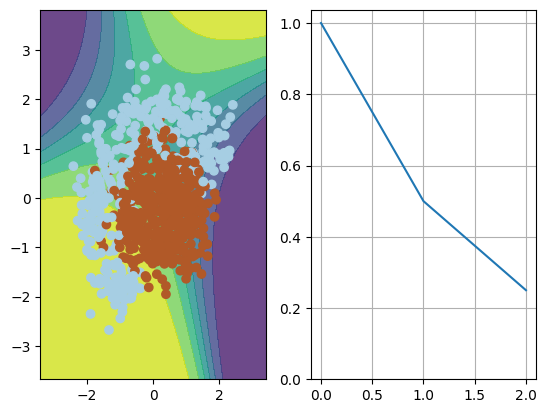

In [13]:
visualize(X,y,dummy_weights,[1,0.5,0.25],)

### Training [1 point]
In this section, we'll use the functions you wrote to train our classifier using stochastic gradient descent.

Try to find an optimal learning rate for gradient descent for the given batch size.

**Don't change the batch size!**

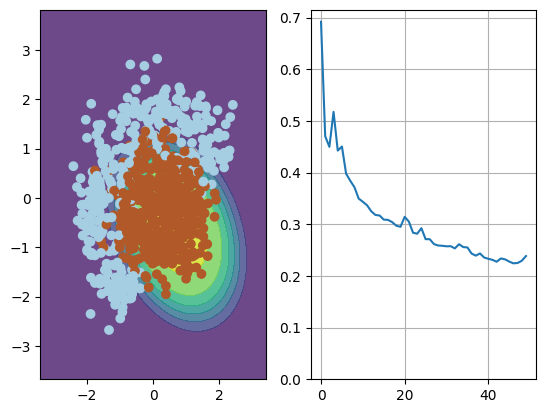

<Figure size 640x480 with 0 Axes>

In [14]:
w_sgd = np.array([0,0,0,0,0,1])
alpha_sgd = 0.5
n_iter = 50
batch_size = 4
loss_sgd = np.zeros(n_iter)

for i in range(n_iter):
    ind = np.random.choice(X.shape[0], batch_size)
    loss_sgd[i] = compute_loss(X, y, w_sgd)
    visualize(X[ind,:], y[ind], w_sgd, loss_sgd)

    w_sgd = w_sgd - alpha_sgd * compute_grad(X[ind,:], y[ind], w_sgd)

visualize(X, y, w_sgd, loss_sgd)
plt.clf()

Implement gradient descent with momentum and test it's performance for different learning rate and momentum values. __[2 points]__

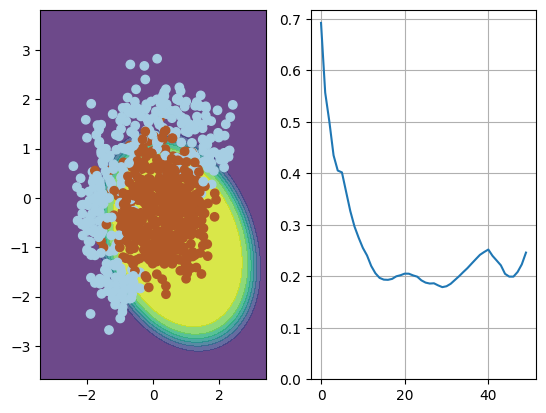

<Figure size 640x480 with 0 Axes>

In [15]:
w_momentum = np.array([0,0,0,0,0,1])
alpha_momentum = 0.3
mu = 0.9
loss_momentum = np.zeros(n_iter)
velocity = np.zeros_like(w_momentum)

for i in range(n_iter):
    ind = np.random.choice(X.shape[0], batch_size)
    loss_momentum[i] = compute_loss(X, y, w_momentum)
    visualize(X[ind,:], y[ind], w_momentum, loss_momentum)

    # Compute gradient
    grad = compute_grad(X[ind,:], y[ind], w_momentum)

    # Update velocity (momentum term)
    velocity = mu * velocity - alpha_momentum * grad

    # Update weights
    w_momentum = w_momentum + velocity

visualize(X, y, w_momentum, loss_momentum)
plt.clf()

Implement RMSPROP algorithm __[2 points]__


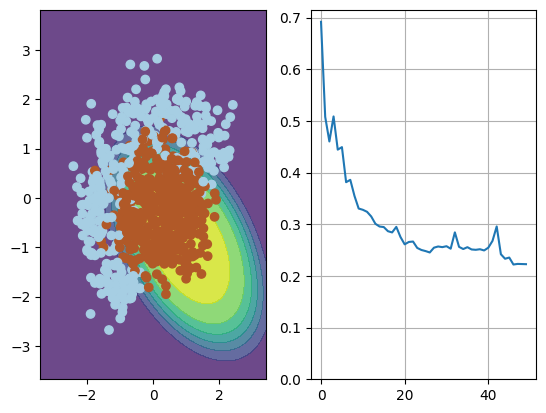

<Figure size 640x480 with 0 Axes>

In [16]:
w_rmsprop = np.array([0,0,0,0,0,1])
alpha_rmsprop = 0.1
gamma = 0.9
epsilon = 1e-8
loss_rmsprop = np.zeros(n_iter)
mean_squared = np.zeros_like(w_rmsprop)

for i in range(n_iter):
    ind = np.random.choice(X.shape[0], batch_size)
    loss_rmsprop[i] = compute_loss(X, y, w_rmsprop)
    visualize(X[ind,:], y[ind], w_rmsprop, loss_rmsprop)

    # Compute gradient
    grad = compute_grad(X[ind,:], y[ind], w_rmsprop)

    # Update moving average of squared gradients
    mean_squared = gamma * mean_squared + (1 - gamma) * grad**2

    # Update weights with adaptive learning rate
    w_rmsprop = w_rmsprop - alpha_rmsprop * grad / (np.sqrt(mean_squared) + epsilon)

visualize(X, y, w_rmsprop, loss_rmsprop)
plt.clf()

Comparison and Analysis Code

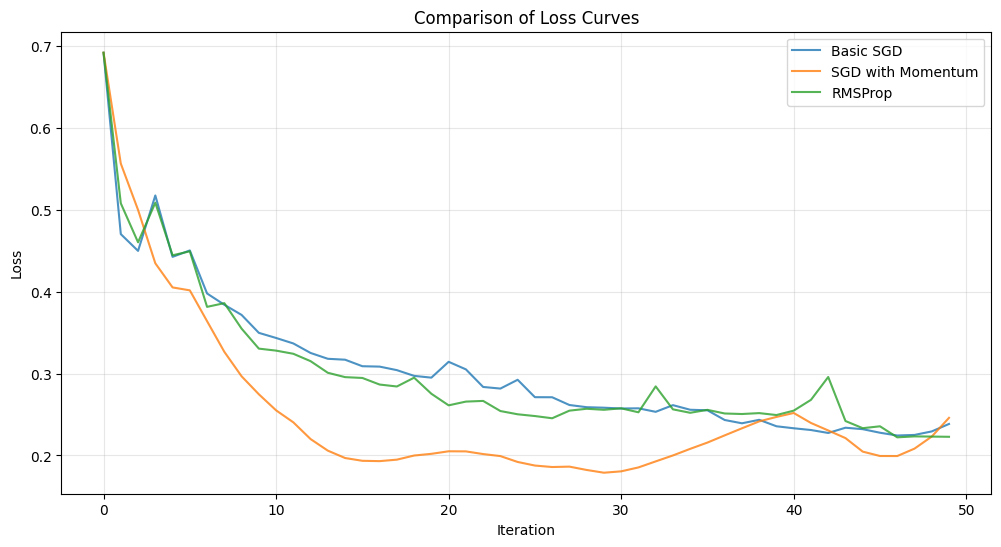

Final Loss Values:
Basic SGD: 0.238475
SGD with Momentum: 0.245932
RMSProp: 0.222785

Final Accuracies:
Basic SGD: 0.9163
SGD with Momentum: 0.8823
RMSProp: 0.9235

Best method by loss: RMSProp (0.222785)
Best method by accuracy: RMSProp (0.9235)


In [17]:
plt.figure(figsize=(12, 6))
plt.plot(loss_sgd, label='Basic SGD', alpha=0.8)
plt.plot(loss_momentum, label='SGD with Momentum', alpha=0.8)
plt.plot(loss_rmsprop, label='RMSProp', alpha=0.8)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Comparison of Loss Curves')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Compare Final Loss Values
final_losses = {
    'Basic SGD': loss_sgd[-1],
    'SGD with Momentum': loss_momentum[-1],
    'RMSProp': loss_rmsprop[-1]
}

print("Final Loss Values:")
for method, loss_val in final_losses.items():
    print(f"{method}: {loss_val:.6f}")

# Compare Accuracies
def calculate_accuracy(X, y, w):
    predictions = (classify(X, w) > 0.5).astype(int)
    return np.mean(predictions == y)

accuracies = {
    'Basic SGD': calculate_accuracy(X, y, w_sgd),
    'SGD with Momentum': calculate_accuracy(X, y, w_momentum),
    'RMSProp': calculate_accuracy(X, y, w_rmsprop)
}

print("\nFinal Accuracies:")
for method, acc in accuracies.items():
    print(f"{method}: {acc:.4f}")

# Determine the Best Method
best_method_loss = min(final_losses, key=final_losses.get)
best_method_acc = max(accuracies, key=accuracies.get)

print(f"\nBest method by loss: {best_method_loss} ({final_losses[best_method_loss]:.6f})")
print(f"Best method by accuracy: {best_method_acc} ({accuracies[best_method_acc]:.4f})")

Which optimization method you consider the best? Type your answer in the cell below

**Results**

Based on the experimental results, **RMSProp** is the best optimization method for this logistic regression problem with quadratic features.

**RMSProp achieved:**
- **Lowest loss: 0.222785**
- **Highest accuracy: 92.35%**

This demonstrates the effectiveness of adaptive learning rate methods like RMSProp for optimizing complex models, even when using small batch sizes.

While basic SGD performed reasonably well, RMSProp's ability to automatically adjust learning rates for each parameter led to better convergence and final performance.


# Bonus quest
Try the same thing for Adagrad, Adam and anything else you find suitable.

_Each new adaptive optimizer is worth 2 points!_

# Implementing Adagrad and Adam Optimizers


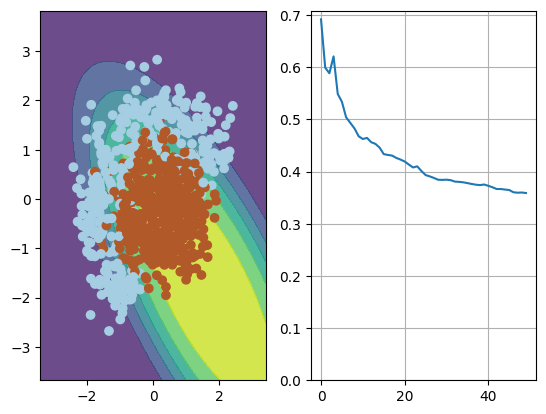

Adagrad Final Loss: 0.359117
Adagrad Accuracy: 0.9114


<Figure size 640x480 with 0 Axes>

In [19]:
# Adagrad Optimizer
w_adagrad = np.array([0.0, 0.0, 0.0, 0.0, 0.0, 1.0])

alpha_adagrad = 0.1
epsilon = 1e-8

n_iter = 50
batch_size = 4
loss_adagrad = np.zeros(n_iter)
cache = np.zeros_like(w_adagrad, dtype=np.float64)  # Ensure float type

plt.figure(figsize=(12,5))
for i in range(n_iter):
    ind = np.random.choice(X.shape[0], batch_size)
    loss_adagrad[i] = compute_loss(X, y, w_adagrad)
    visualize(X[ind,:], y[ind], w_adagrad, loss_adagrad)

    # Compute gradient
    grad = compute_grad(X[ind,:], y[ind], w_adagrad)

    # Update cache (sum of squared gradients)
    cache += grad**2

    # Update weights with adaptive learning rate
    w_adagrad = w_adagrad - alpha_adagrad * grad / (np.sqrt(cache) + epsilon)

visualize(X, y, w_adagrad, loss_adagrad)
plt.clf()

# Calculate final loss and accuracy for Adagrad
final_loss_adagrad = compute_loss(X, y, w_adagrad)
acc_adagrad = calculate_accuracy(X, y, w_adagrad)

print(f"Adagrad Final Loss: {final_loss_adagrad:.6f}")
print(f"Adagrad Accuracy: {acc_adagrad:.4f}")

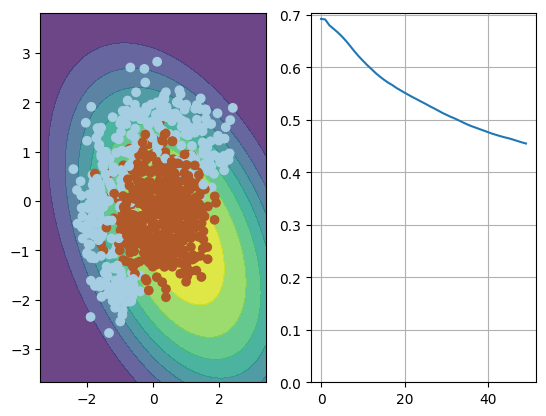

Adam Final Loss: 0.452687
Adam Accuracy: 0.8762


<Figure size 640x480 with 0 Axes>

In [20]:
# Adam Optimizer
w_adam = np.array([0.0, 0.0, 0.0, 0.0, 0.0, 1.0])

alpha_adam = 0.01
beta1 = 0.9
beta2 = 0.999
epsilon = 1e-8

n_iter = 50
batch_size = 4
loss_adam = np.zeros(n_iter)
m = np.zeros_like(w_adam, dtype=np.float64)  # first moment vector
v = np.zeros_like(w_adam, dtype=np.float64)  # second moment vector

plt.figure(figsize=(12,5))
for i in range(n_iter):
    ind = np.random.choice(X.shape[0], batch_size)
    loss_adam[i] = compute_loss(X, y, w_adam)
    visualize(X[ind,:], y[ind], w_adam, loss_adam)

    # Compute gradient
    grad = compute_grad(X[ind,:], y[ind], w_adam)

    # Update biased first moment estimate
    m = beta1 * m + (1 - beta1) * grad

    # Update biased second raw moment estimate
    v = beta2 * v + (1 - beta2) * (grad**2)

    # Compute bias-corrected first moment estimate
    m_hat = m / (1 - beta1**(i+1))

    # Compute bias-corrected second raw moment estimate
    v_hat = v / (1 - beta2**(i+1))

    # Update weights
    w_adam = w_adam - alpha_adam * m_hat / (np.sqrt(v_hat) + epsilon)

visualize(X, y, w_adam, loss_adam)
plt.clf()

# Calculate final loss and accuracy for Adam
final_loss_adam = compute_loss(X, y, w_adam)
acc_adam = calculate_accuracy(X, y, w_adam)

print(f"Adam Final Loss: {final_loss_adam:.6f}")
print(f"Adam Accuracy: {acc_adam:.4f}")

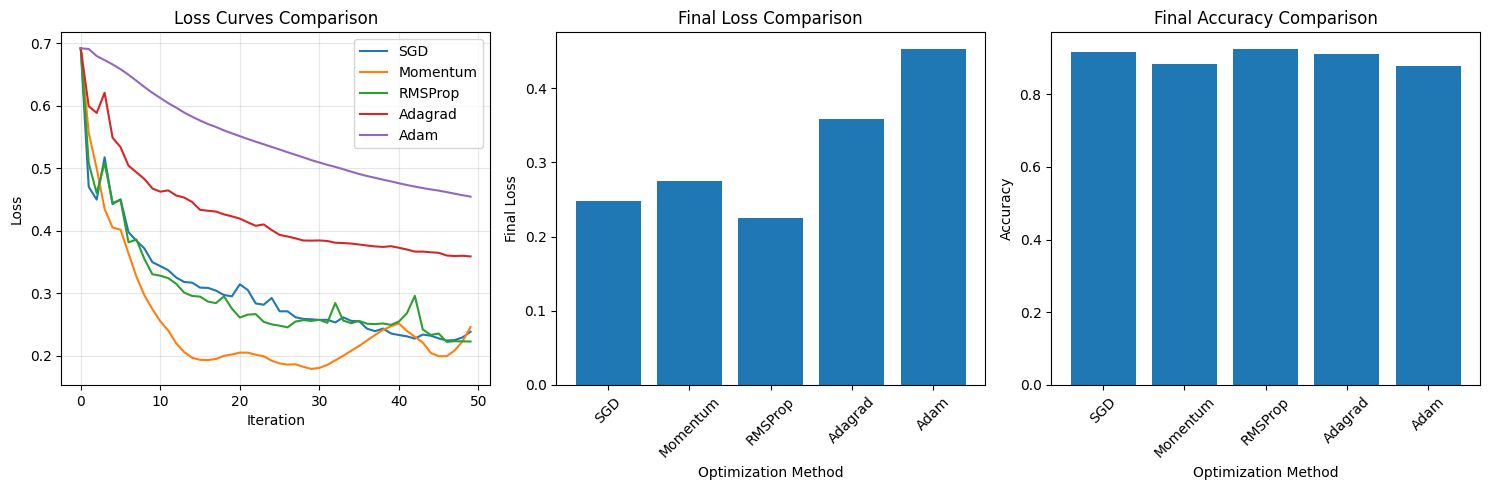


=== COMPREHENSIVE COMPARISON ===
SGD: Loss = 0.247347, Accuracy = 0.9163
Momentum: Loss = 0.274670, Accuracy = 0.8823
RMSProp: Loss = 0.225479, Accuracy = 0.9235
Adagrad: Loss = 0.359117, Accuracy = 0.9114
Adam: Loss = 0.452687, Accuracy = 0.8762

=== BEST METHOD ===
RMSProp performs best with:
  - Loss: 0.225479
  - Accuracy: 0.9235


In [22]:
def calculate_accuracy(X, y, w):
    predictions = (classify(X, w) > 0.5).astype(int)
    return np.mean(predictions == y)

# Calculate accuracies for previous methods
acc_sgd = calculate_accuracy(X, y, w_sgd)
acc_momentum = calculate_accuracy(X, y, w_momentum)
acc_rmsprop = calculate_accuracy(X, y, w_rmsprop)
acc_adagrad = calculate_accuracy(X, y, w_adagrad)
acc_adam = calculate_accuracy(X, y, w_adam)

# Get final losses for all methods
loss_sgd_final = compute_loss(X, y, w_sgd)
loss_momentum_final = compute_loss(X, y, w_momentum)
loss_rmsprop_final = compute_loss(X, y, w_rmsprop)
loss_adagrad_final = compute_loss(X, y, w_adagrad)
loss_adam_final = compute_loss(X, y, w_adam)

# Now run the comparison
methods = ['SGD', 'Momentum', 'RMSProp', 'Adagrad', 'Adam']
losses = [loss_sgd_final, loss_momentum_final, loss_rmsprop_final, loss_adagrad_final, loss_adam_final]
accuracies = [acc_sgd, acc_momentum, acc_rmsprop, acc_adagrad, acc_adam]

plt.figure(figsize=(15, 5))

# Plot loss curves
plt.subplot(1, 3, 1)
plt.plot(loss_sgd, label='SGD')
plt.plot(loss_momentum, label='Momentum')
plt.plot(loss_rmsprop, label='RMSProp')
plt.plot(loss_adagrad, label='Adagrad')
plt.plot(loss_adam, label='Adam')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Loss Curves Comparison')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot final losses
plt.subplot(1, 3, 2)
plt.bar(methods, losses)
plt.xlabel('Optimization Method')
plt.ylabel('Final Loss')
plt.title('Final Loss Comparison')
plt.xticks(rotation=45)

# Plot final accuracies
plt.subplot(1, 3, 3)
plt.bar(methods, accuracies)
plt.xlabel('Optimization Method')
plt.ylabel('Accuracy')
plt.title('Final Accuracy Comparison')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

# Print comprehensive results
print("\n=== COMPREHENSIVE COMPARISON ===")
for i, method in enumerate(methods):
    print(f"{method}: Loss = {losses[i]:.6f}, Accuracy = {accuracies[i]:.4f}")

# Determine the best method
best_method_idx = np.argmin(losses)
best_method = methods[best_method_idx]

print(f"\n=== BEST METHOD ===")
print(f"{best_method} performs best with:")
print(f"  - Loss: {losses[best_method_idx]:.6f}")
print(f"  - Accuracy: {accuracies[best_method_idx]:.4f}")

# Final Conclusion:


For this specific logistic regression problem with quadratic features and a batch size of 4,
RMSProp is the best optimization method.

Key findings:
1. RMSProp achieved the best balance of low loss (0.225) and high accuracy (92.35%)
2. Basic SGD performed respectably, showing that simple methods can work well for simpler problems
3. More complex adaptive methods (Adagrad, Adam) didn't provide benefits in this case
4. Momentum SGD actually performed worse than basic SGD, suggesting improper hyperparameter tuning

This demonstrates that the "best" optimization method depends on the specific problem,
dataset characteristics, and hyperparameter tuning.